## Библиотеки

In [437]:
#!pip install markov_clustering

In [1]:
import pandas as pd
import numpy  as np
import markov_clustering as mc
import matplotlib.pyplot as plt
import math
import pytz
import folium
import os.path
import networkx as nx


from haversine       import haversine, Unit
from collections     import Counter
from datetime        import datetime
from timezonefinder  import TimezoneFinder
from IPython.display import clear_output

## Используемые функции

### Utility functions

In [2]:
# для отбрасывания значащих цифр в координатах
def skip(x,n):
    return int(x*(10**n))/10**n

# расстояние в километрах
def dist_km(lat_1, lon_1, lat_2, lon_2): 
    var_1 = (lat_1, lon_1)
    var_2 = (lat_2, lon_2)
    return haversine(var_1, var_2, Unit.KILOMETERS)

# Изменения цвета фигуры на карте в зависимости от вероятности
def color_change(prob):# для визуализации на крате
    if(prob > 0.66):
        return('red')
    elif(0.33 <= prob <0.66):
        return('yellow')
    else:
        return('green')
    
# Датасет не должен быть очень большим возможно переполнение памяти    
def data_load(path):

    #"/home/lars/Загрузки/coord1000.csv"

    data = pd.read_csv(path).dropna()
    data = data.drop("Unnamed: 0", axis=1)
    Time = []
    Date = []
    for i in data['event_time']:
        date,time = i.split(' ')
        time = time.split('.')[0]
        Time.append(time)
        Date.append(date)
    data['Date'] = Date
    data['Time'] = Time
    data = data.sort_values(by = ['user_id','Date', 'Time'])
    data = data.reset_index().drop('index', axis=1)
    data = data.drop('event_time', axis=1)
    data.rename(columns={'latitude':'lat', 'longitude':'lon'}, inplace = True)
    data.drop('event_dt', axis=1, inplace=True)

    names = list(set(data['user_id']))
    
    return data, names

def path_check(name, base="/home/lars/kek/", end = ".npz"):
    
    return os.path.exists(base+name+end)

### Функции параметра старения

In [3]:
def sigmoid_dt_(x,y, k = 4.5584, beta = 7.0910, step_osn = 2.0762, h_b=0.95, l_b=0.85): # альфа для устаревания
    #x,y - дата и время в виде строки, формат в функциях выше, разность всегда положительная
    # k - основание логарифма
    # b - beta
    dist = minutes_between_high(y,x)
    res = 1 - 1.0/(1+step_osn**(-(math.log(dist+k)/math.log(k)-beta)))
    if(res>=h_b):
        return h_b
    if(res<=l_b):
        return l_b
    return res

def sigmoid_dt(x,y, k = 3.3, beta = 5.6):
    #x,y - дата и время в виде строки, формат в функциях выше, разность всегда положительная
    # k - основание логарифма
    # b - beta
    k = k
    b = beta
    dist = minutes_between_high(y,x)
    #print(dist,'minutes')
    res = 1-1.0/(1+math.exp(-(math.log(dist+k,k)-b)))
    if(res>=0.95):
        return 0.95
    if(res<=0.5):
        return 0.5
    return res

### Функции работы со временем

In [4]:
#количество минут между двумя событиями
def minutes_between_high(d1, d2):
    d1 = datetime.strptime(d1, "%H:%M:%S %Y-%m-%d")
    d2 = datetime.strptime(d2, "%H:%M:%S %Y-%m-%d")
    dif = abs(d2-d1)
    return (dif.days*24*60+dif.seconds//60)


from datetime import timedelta
# Получение смещения относительно установленной часовой зоны
def time_difference(lat,lon,param = 'utc'):
    
    tf       = TimezoneFinder()
    try:
        tzz      = tf.timezone_at(lng=lon, lat=lat)
        timezone = pytz.timezone(tzz)
        dt       = datetime.now()
        utc_diff = timezone.utcoffset(dt)
    except BaseException:
        utc_diff = timedelta(seconds=10800)
    
    if(param=='utc'):
        return utc_diff
    elif(param=='msc'):
        msc_delta = timedelta(seconds=10800)
        return (utc_diff-msc_delta)
    
# Локализация времени
def dataFrame_localization(data, param='msc',debug=False):
    
    i=0
    for lat,lon,time,date in zip(data['lat'], data['lon'], data['Time'], data['Date']):
        
        if(debug):
            print(lat,lon)
        dt = datetime.strptime(time+' '+date, "%H:%M:%S %Y-%m-%d")
        dt+= time_difference(lat,lon, param=param)
        data.loc[i,'Time'], data.loc[i,'Date'] = str(dt.time()), str(dt.date())
        i+=1
        
# Предлагаемое разбиение дня на части
noch = [datetime.strptime("00:00:00", "%H:%M:%S"),datetime.strptime("04:00:00", "%H:%M:%S")]
utro = [datetime.strptime("04:00:00", "%H:%M:%S"),datetime.strptime("09:00:00", "%H:%M:%S")]
den  = [datetime.strptime("09:00:00", "%H:%M:%S"),datetime.strptime("17:00:00", "%H:%M:%S")]
vecher_1 = [datetime.strptime("17:00:00", "%H:%M:%S"),datetime.strptime("20:30:00", "%H:%M:%S")]
vecher_2 = [datetime.strptime("20:30:00", "%H:%M:%S"),datetime.strptime("00:00:00", "%H:%M:%S")]


# Добавление в сэмплу пользователя колонок обозначающих часть дня и день недели транзакции
def selection_2(person):
    person = person.groupby(['Date', 'Time']).apply(pd.DataFrame.reset_index)
    person = person.iloc[:,[1,2,3,4,5]].reset_index(drop=True)
    lol = pd.to_datetime(person['Date']).dt.dayofweek
    oh = []
    for i in range(len(person)):
        tmp = datetime.strptime(person.loc[i]['Time'], "%H:%M:%S")
        if(noch[0]<=tmp<=noch[1]):
            oh.append(0)
        elif(utro[0]<=tmp<=utro[1]):
            oh.append(1)
        elif(den[0]<=tmp<=den[1]):
            oh.append(2)
        elif(vecher_1[0]<=tmp<=vecher_1[1]):
            oh.append(3)
        else:
            oh.append(4)
    person['Part_day'] = pd.Series(oh)
    person['Day_week'] = pd.to_datetime(person['Date']).dt.dayofweek
    return person

### Функции для работы с картой

In [5]:
# норма пространства l1
def l1_norm(x1,y1,x2,y2): 
    return abs(x1-x2)+abs(y1-y2)


# норма пространства l2
def l2_norm(x1,y1,x2,y2): 
    return dist_km(x1,y1,x2,y2)


# проверка попадания в область
def check_incl(s,x,y, val, norm = l1_norm, use_norm=True):  
    
    #PARAMS
    # s - координаты центра области, записанные в строке с разделителем пробел
    # x, y - latitude and lontitude транзакции
    # val - float радиус или сторона круга(квадрата) для проверки попадания
    # norm - какую норму использовать (l1_norm l2_norm) аргумент - функция
    # use_norm - если false, то будет определяться по градусам абсолютного 
    # отклонения по каждой из координат
    
    keki = s.split(' ')
    o = float(keki[0])
    h = float(keki[1])
    if(not use_norm):
        if((abs(o-x)<val) and (abs(h-y))<val*2):
            return True
        else:
            return False
    if(norm(o,h,x,y)<val):
        return True
    else:
        return False

# Аналогично предыдущему, только с параметрами в обе строки    
def check_incl2(s,S, val, norm = l2_norm, use_norm=True):
    keki = s.split(' ')
    o = float(keki[0])
    h = float(keki[1])
    keki2 = S.split(' ')
    x = float(keki2[0])
    y = float(keki2[1])
    if(not use_norm):
        if((abs(o-x)<val) and (abs(h-y))<val*2):
            return True
        else:
            return False
    if(norm(o,h,x,y)<val):
        #print("Distance",norm(o,h,x,y),'radius',val)
        return True
    else:
        return False

    
    
# Перерасчёт центра области, при попадании координаты 
# в уже существующий круг на основе центров на уровень ниже
def re_count(s,x,y,mas,l1,l2, val, norm = l1_norm):
    
    #PARAMS
    # s - координаты центра области, записанные в строке с разделителем пробел
    # x, y - latitude and lontitude транзакции
    # l1, l2 - уровни на которых идёт перерасчёт центра l2 на один ниже l1 на самом низком 
    # уровне перерасчёт не происходит
    
    l2 = l1+1
    s2 = s.split(' ')
    laats = []
    loons = []
    w1 = float(s2[0])
    w2 = float(s2[1])
    if(l1==(len(mas)-1)):#обновление на самом низком уровне
        w1 = str((w1+x)/2)
        w2 = str((w2+y)/2)
        return w1+' '+w2
    for op in range(len(mas[l2])):#смотрим координаты каких квадратов попали в рассматривмаемый квадрат уровня l1
        s2 = mas[l2][op].split(' ')
        if(norm(w1,w2,float(s2[0]), float(s2[1]))<val):
            laats.append(float(s2[0]))
            loons.append(float(s2[1]))
            
    w1 = str((sum(laats)+x)/(len(laats)+1))
    w2 = str((sum(loons)+y)/(len(loons)+1))
    
    # возвращаемое значение - строка 'new_lat new_lon'
    return(w1+' '+w2)

def re_count2(s,x,y,mas,l1,l2, val, norm = l1_norm):#перерасчёт центра области 2 (override)
    l2 = l1+1
    s2 = s.split(' ')
    laats = []
    loons = []
    w1 = float(s2[0])
    w2 = float(s2[1])
    if(l1==2):#обновление на самом низком уровне
        w1 = str((w1+x)/2)
        w2 = str((w2+y)/2)
        return w1+' '+w2
    for op in mas[l2]:#смотрим координаты каких квадратов попали в рассматривмаемый квадрат уровня l1
        s2 = op.split(' ')
        if(norm(w1,w2,float(s2[0]), float(s2[1]))<val):
            laats.append(float(s2[0]))
            loons.append(float(s2[1]))
    #print(s, laats, loons)
    w1 = str((sum(laats)+x)/(len(laats)+1))
    w2 = str((sum(loons)+y)/(len(loons)+1))
    return(w1+' '+w2) 

def otbor_ver2(num, level, massive, mas):
    
    # num - количество вероятностных кластеров с уровня
    # level - на каком уровне проводить отбор
    # massive - массив координат вероятностных кластеров
    # mas - массив вероятностей соответствующих кластерам
    
    tmp_ver = np.array([-1.0]*num)
    tmp_idx = np.array([0]*num)
    for i in range(len(mas[level])):
        kek = mas[level][i]
        for j in range(num):
            if tmp_ver[j]<=kek:
                tmp_ver[j+1:]=tmp_ver[j:-1]
                tmp_idx[j+1:]=tmp_idx[j:-1]
                tmp_ver[j]=kek
                tmp_idx[j]=i
                break
    op = num
    for j in range(len(tmp_idx)):
        if(tmp_ver[-(j+1)]>-1):
            if(j==0):
                #print("All done")
                break
            #print(num-j, "none zero squares")
            op = num-j
            break
    coordinates = []
    probs = []
    for i in range(op):
        coordinates.append(massive[level][tmp_idx[i]])
        probs.append(mas[level][tmp_idx[i]])
    return coordinates, probs


def low_level_map(usr1,day, part_day,border=1):
    # возвращает карту для уровня с границей указанной в border в километрах
    # для заданной части дня и дня недели, если транзакций в этот период не зафиксированно, возвращает
    # глобальную карту составленную с данной границей
    
    border*=10 # необходимо для корректной работы
    
    
    VALUE = 10.0
    #border = 1000
    NORM = l2_norm
        
    ss = usr1.loc[usr1['Day_week']==day]
    l = ss.shape[0]
        
    if(l>=2):                      #формируем наиболее подходящий радиус, если достаточно наблюдений
        sred_lat = ss['lat'].mean()
        sred_lon = ss['lon'].mean()
        su = 0.0
        for i,j in zip(ss['lat'], ss['lon']):
            su+=dist_km(i,j,sred_lat,sred_lon)
        border = su/l*100

    last_t=0
    tmp = (usr1.loc[(usr1['Part_day']==part_day) & (usr1['Day_week']==day)]).iloc[:,:-2]
    fl =True
    if(len(tmp!=0)):    
        gmassive = list(np.ndarray(shape=(1,1), dtype=object))
        gvalues = list(np.ndarray(shape=(1,1), dtype=float))
        gprobs = list(np.ndarray(shape=(1,1), dtype=float))
        for i in tmp.index:

            dt = ' '.join(tmp.loc[i,['Time','Date']].values)
            p  = tmp.loc[i,['lat','lon']].values

            if(fl):
                tok=True
                fl=False
            else:
                tok=False
            last_t, gmassive, gvalues, gprobs = update_mg(p, dt, last_t, gmassive, gvalues, gprobs,border,norm=l2_norm, tok=tok)
                    #print(last_t)
    else:
        gmassive, gvalues, gprobs =  cluster2(usr1, border=border)

            
    return gmassive, gvalues, gprobs

def archivate_maps(data, names, base = "/home/lars/kek/",level  = 1,levels = 4,border = 100):
    num=0
    end=len(names)
    for i in names:
        num+=1
        clear_output(wait=True)
        print("Map archivation",str(num/end*100),"%")

        usr1 = data[data['user_id']==i]
        usr1 = usr1.reset_index(drop=True)

        if(not usr1.isnull().values.any()):
            dataFrame_localization(usr1)
            usr1 = selection_2(usr1)

            _,massive, values, probs = cluster(data,i,level,levels=levels, border = border, aging=False,re_c=False)
            gm1,gv1,gp1 = global_map(usr1,border = border*(10**(-(levels-2))), 
                                     aging=False, sq=True, re_c=False)


            np.savez(base+i, massive, values, probs)

            for j in range(len(gm1)):
                np.savez(base+i+"g"+str(j),gm1[j],gv1[j],gp1[j])

        else:
            print("lol",i)
    

def load_maps(uid, base="/home/lars/kek/"):
    
    if(not path_check(uid, base=base)):
        return 0,0,0,0,0,0
    
    f = np.load(base+uid+".npz",allow_pickle = True)
    m,v,p = f['arr_0'],f['arr_1'],f['arr_2']
    
    gm, gv, gp = [],[],[]
    
    for j in range(35):
        f = np.load(base+uid+"g"+str(j)+".npz",allow_pickle = True)
        gm.append(f['arr_0'])
        gv.append(f['arr_1'])
        gp.append(f['arr_2'])
    
    return m,v,p,gm,gv,gp

### Функции знакомства

In [6]:
def convert(m, l1=0.05,l2=0.10,l3=0.2):
    assert l1+l2+l3<1
    assert l1<=l2 and l2<=l3
    
    print(m)
    
    return m[0]*l1+m[1]*l2+m[2]*l3, 1.0-l1-l2-l3

def convert_2(m, l1=0.15,l2=0.2):
    assert l1+l2<1
    assert l1<=l2
    
    return m[0]*l1+m[1]*l2, 1.0-l1-l2


    
def znak(m1,p1, m2, p2,ran = [100,10,1,0.1], sq=True):
    probs = []
    for i in range(len(m2)-1):
        p=0.0                                        # вероятность по уровню
        for j in range(len(m1[i])):                  # бежим по побее высокому уровню референсного
            su=0.0                                   # сумма вероятностей попавших в референсный круг
            for z in range(len(m2[i+1])):            # бежим по на уровень ниже уровню, для соотносимого
                if(check_incl2(m1[i][j],m2[i+1][z],ran[i])):
                    su+=p2[i+1][z]
            if(sq):
                p+= np.sqrt(p1[i][j]*su)
            else:
                p+= p1[i][j]*su
        probs.append(p)
    if(len(m1)==3):
        return convert_2(probs)
    elif(len(m1)==4):
        return convert(probs)
    



def low_level_znakomstvo(usr1, usr2, pogr=100, local=True, aging=True, sq=True, re_c=True,
                        low_level_border =10, pairs=5):
    
    if(local):
        
        dataFrame_localization(usr1)
        dataFrame_localization(usr2)
    
    usr1 = selection_2(usr1)
    usr2 = selection_2(usr2)
    
    
    
    dist = pd.DataFrame(columns=['idx','dist'])
    
    gm1,gv1,gp1 = global_map(usr1,border = low_level_border, aging=aging, sq=sq, re_c=re_c)
    gm2,gv2,gp2 = global_map(usr2,border = low_level_border, aging=aging, sq=sq, re_c=re_c)
    
    op=0
    
    for m1, m2, p1, p2 in zip(gm1, gm2, gp1, gp2):
        # будем для каждого пользователя на предпоследнем уровне искать центр тяжести кластеров,
        #  потом считаем расстояние между ними и пять наиулчших запоминаем
        lats1 = np.array([])
        lons1 = np.array([])
        
        lats2 = np.array([])
        lons2 = np.array([])
        
        for i in m1[-2]:
            s1 = i.split(' ')
            lats1 = np.append(lats1,float(s1[0]))
            
            lons1 = np.append(lons1, float(s1[1]))
        
        
        for j in m2[-2]:
            s2 = j.split(' ')
            lats2 = np.append(lats2,float(s2[0]))
            lons2 = np.append(lons2, float(s2[1]))
            
        clt_1, cln_1 = lats1@p1[-2],lons1@p1[-2]
        clt_2, cln_2 = lats2@p2[-2],lons2@p2[-2]
        
        dist = dist.append({'idx':op,'dist':dist_km(clt_1, cln_1,clt_2, cln_2)}, ignore_index=True)
        op+=1
    dist = dist.sort_values(by='dist', ascending=False).reset_index(drop=True)
    idx = dist.loc[:pairs-1,'idx']
    
    total=0.0
    prob = 0.0
    
    for i in idx:
        
        coords1, p1  = otbor_ver2(4,-1,gm1[int(i)],gp1[int(i)])
        coords2, p2  = otbor_ver2(4,-1,gm2[int(i)],gp2[int(i)])
        
        lats1 = np.array([])
        lons1 = np.array([])
        
        lats2 = np.array([])
        lons2 = np.array([])
        
        for S1 in coords1:
            s1 = S1.split(' ')
            lats1 = np.append(lats1,float(s1[0]))
            
            lons1 = np.append(lons1,float(s1[1]))
            
        for S2 in coords2:
            s2 = S2.split(' ')
            lats2 = np.append(lats2,float(s2[0]))
            
            lons2 = np.append(lons2,float(s2[1]))
        
        pogr = 100
        
        for lt1, ln1,pr1 in zip(lats1, lons1, p1):
            k=0
            prob=0.0
            for lt2, ln2,pr2 in zip(lats2, lons2, p2):
            
                rng = l2_norm(lt1, ln1, lt2, ln2)# into meters
                k+=1
                if(rng<1):
                    if(rng<0.1):
                        prob+=np.sqrt(pr1*pr2)
                    else:
                        prob += np.sqrt(pr1*pr2)/(1.1)
                    #prob += np.sqrt(pr1*pr2)*100/pogr
                else:
                    prob += np.sqrt(pr1*pr2)/rng
            total += prob
    
    return total*1.0/len(idx)



def znakomstvo(data, uid1, uid2, low_level_border = 10,aging=True, sq=True, re_c=True, pairs=5, 
               debug = False, levels=4, border=100):# объединение 1-го и 2-го этапов знакомства
    
    ran = [100,10,1,0.1] # массив радиусов кругов для проверки попадания
    map1, m1, v1, p1 = cluster(data,uid1,level=0,levels=levels, border = border, aging=aging, re_c=re_c)
    map1, m2, v2, p2 = cluster(data,uid2,level=0,levels=levels, border = border, aging=aging, re_c=re_c)
    
    p1, l4 = znak(m1,p1,m2,p2, sq=sq)
    p1 = min(p1,1-l4)
    if(debug):
        print("p1", p1)
    #print("p1",p1)
    
    usr1 = data.loc[data['user_id']==uid1]
    usr1 = usr1.groupby(['Date', 'Time']).apply(pd.DataFrame.reset_index)
    usr1 = usr1.iloc[:,[1,2,3,4,5]].reset_index(drop=True)


    usr2 = data.loc[data['user_id']==uid2]
    usr2 = usr2.groupby(['Date', 'Time']).apply(pd.DataFrame.reset_index)
    usr2 = usr2.iloc[:,[1,2,3,4,5]].reset_index(drop=True)

    p2 = min(l4*low_level_znakomstvo(usr1, usr2, local=False, low_level_border = low_level_border,
                                 aging=aging, sq=sq, re_c=re_c, pairs=pairs), l4)
    if(debug):
        print("p2", p2)
    #print("p2",p2,"l4",l4)
    
    #print("Вероятность знакомства",round((p1+p2)*100,2),"%")
    return round((p1+p2),2)

def check_znak(m1,p1,m2,p2, treshold = 100):
    lats1 = np.array([])
    lons1 = np.array([])
        
    lats2 = np.array([])
    lons2 = np.array([])
        
    for i in m1[-2]:
        s1 = i.split(' ')
        lats1 = np.append(lats1,float(s1[0]))
            
        lons1 = np.append(lons1, float(s1[1]))
        
        
    for j in m2[-2]:
        s2 = j.split(' ')
        lats2 = np.append(lats2,float(s2[0]))
        lons2 = np.append(lons2, float(s2[1]))
            
    clt_1, cln_1 = lats1@p1[-2],lons1@p1[-2]
    clt_2, cln_2 = lats2@p2[-2],lons2@p2[-2]
    
    if(dist_km(clt_1, cln_1, clt_2, cln_2)<treshold):
        return True
    return False

def graph_preparation(data, names, base):
    
    names_pairs = [(i, j) for i in names for j in names if i<j]
    
    f = np.load("/home/lars/kek/"+names_pairs[0][0]+".npz",allow_pickle = True)
    
    last_u = names_pairs[0][0]
    
    library_znakomstv = {}
    
    u1m = f['arr_0']
    u1p = f['arr_2']
    
    tmp_mas = []
    
    num = 1.0
    end = len(names_pairs)
    
    for i in names_pairs:
        
        
        if(num%20000==0):
            clear_output(wait=True)
            print("Graph preparation",str(num/end*100),"%")
        
        num+=1
        u1, u2 = i[0], i[1]
        if(path_check(u1) and path_check(u2)):
            
            if(u1 != last_u):
                
                if(len(tmp_mas)>0):
                    library_znakomstv[last_u] = set(tmp_mas)
                tmp_mas = []
                
                f = np.load("/home/lars/kek/"+u1+".npz",allow_pickle = True)
                last_u = u1
                u1m = f['arr_0']
                u1p = f['arr_2']
                
            f = np.load("/home/lars/kek/"+u2+".npz",allow_pickle = True)
            u2m = f['arr_0']
            u2p = f['arr_2']
            
            if(check_znak(u1m,u1p,u2m,u2p)):
                tmp_mas.append(u2)
                
    return library_znakomstv

def graph_forming(lib, prob_lib, treshold=0.1):
    list_lib_values = list(lib.values())
    
    total = []
    for i in list_lib_values:
        for j in i:
            total.append(j)
    total = set(total)
    keys = prob_lib.keys()
    
    c = set(total | set(list(keys)))
    c = sorted(list(c))
    
    graph = np.zeros(shape=(len(c),len(c)), dtype=float)
    
    for i in range(len(c)):
        key = c[i]
        if(key not in keys):
            continue
        for j in range(i+1, len(c)):
            value = c[j]
            if(value not in lib[key]):
                continue
            vals = list(lib[key])
            p = prob_lib[key][vals.index(value)]
            if(p>treshold):
                #if(p>0.5):
                    #assert p==znakomstvo_lib(data, c[i], c[j])
                graph[i,j] = p
    graph = graph.T+graph
    
    return graph

def low_level_znakomstvo_lib(gm1,gp1,gm2,gp2, pairs=5):
    
    dist = pd.DataFrame(columns=['idx','dist'])
    op=0
    
    for m1, m2, p1, p2 in zip(gm1, gm2, gp1, gp2):
        # будем для каждого пользователя на предпоследнем уровне искать центр тяжести кластеров,
        #  потом считаем расстояние между ними и пять наиулчших запоминаем
        lats1 = np.array([])
        lons1 = np.array([])
        
        lats2 = np.array([])
        lons2 = np.array([])
        
        for i in m1[-2]:
            s1 = i.split(' ')
            lats1 = np.append(lats1,float(s1[0]))
            
            lons1 = np.append(lons1, float(s1[1]))
        
        
        for j in m2[-2]:
            s2 = j.split(' ')
            lats2 = np.append(lats2,float(s2[0]))
            lons2 = np.append(lons2, float(s2[1]))
            
        clt_1, cln_1 = lats1@p1[-2],lons1@p1[-2]
        clt_2, cln_2 = lats2@p2[-2],lons2@p2[-2]
        
        dist = dist.append({'idx':op,'dist':dist_km(clt_1, cln_1,clt_2, cln_2)}, ignore_index=True)
        op+=1
    dist = dist.sort_values(by='dist', ascending=False).reset_index(drop=True)
    idx = dist.loc[:pairs-1,'idx']
    
    total=0.0
    prob = 0.0
    
    for i in idx:
        
        coords1, p1  = otbor_ver2(4,-1,gm1[int(i)],gp1[int(i)])
        coords2, p2  = otbor_ver2(4,-1,gm2[int(i)],gp2[int(i)])
        
        lats1 = np.array([])
        lons1 = np.array([])
        
        lats2 = np.array([])
        lons2 = np.array([])
        
        for S1 in coords1:
            s1 = S1.split(' ')
            lats1 = np.append(lats1,float(s1[0]))
            
            lons1 = np.append(lons1,float(s1[1]))
            
        for S2 in coords2:
            s2 = S2.split(' ')
            lats2 = np.append(lats2,float(s2[0]))
            
            lons2 = np.append(lons2,float(s2[1]))
        
        pogr = 100
        
        for lt1, ln1,pr1 in zip(lats1, lons1, p1):
            k=0
            prob=0.0
            for lt2, ln2,pr2 in zip(lats2, lons2, p2):
            
                rng = l2_norm(lt1, ln1, lt2, ln2)# into meters
                k+=1
                if(rng<1):
                    if(rng<0.1):
                        prob+=np.sqrt(pr1*pr2)
                    else:
                        prob += np.sqrt(pr1*pr2)/(1.1)
                    #prob += np.sqrt(pr1*pr2)*100/pogr
                else:
                    prob += np.sqrt(pr1*pr2)/rng
            total += prob
    
    return total*1.0/len(idx)

def znakomstvo_lib(data, uid1, uid2, base="/home/lars/kek/",low_level_border = 10,
                   debug=False,
                   aging=True, sq=True, re_c=True, pairs=5):
    
    m1, _, p1, gm1, _, gp1 = load_maps(uid1,base=base) 
    m2, _, p2, gm2, _, gp2 = load_maps(uid2,base=base) 
    
    if(type(m1)==int or type(m2)==int):
        return 0
    
    p1, l4 = znak(m1,p1,m2,p2, sq=sq)
    p1 = min(p1,1-l4)
    
    if(debug):
        print("p1", p1)
    
    p2 = min(l4*low_level_znakomstvo_lib(gm1,gp1,gm2,gp2, pairs), l4)
    if(debug):
        print("p2", p2)
    return round((p1+p2),2)

def znakomstvo_by_lib(lib, data, aging=False, sq=True, re_c=False, pairs=5):
    
    keys = list(lib.keys())
    
    prob_lib = {}
    
    num=1.0
    
    for k in keys:
        clear_output(wait=True)
        print("Znakomstvo by lib",str(num/len(keys)*100), "%")
        num+=1
        tmp = []
        for v in lib[k]:
            tmp.append(znakomstvo_lib(data, k, v, base="/home/lars/kek/",aging=aging, 
                                      sq=sq, re_c=re_c, pairs=pairs))
        prob_lib[k] = tmp[:]
        
        
    return prob_lib

def load_libs(base="/home/lars/kek"):
    f = np.load(base+"/lib_keys"+".npz",allow_pickle = True)
    lib_keys = f['arr_0']
    f = np.load(base+"/lib_values"+".npz",allow_pickle = True)
    lib_values = f['arr_0']
    f = np.load(base+"/prob_lib_keys"+".npz",allow_pickle = True)
    prob_lib_keys = f['arr_0']
    f = np.load(base+"/prob_lib_values"+".npz",allow_pickle = True)
    prob_lib_values = f['arr_0']
    
    lib = {k:v for k,v in zip(lib_keys,lib_values)}
    prob_lib = {k:v for k,v in zip(prob_lib_keys,prob_lib_values)}
    
    return lib, prob_lib

def clusters_to_ids(lib, prob_lib, clusters, number):
    cluster1   = list(clusters[number])
    total = []
    for i in list(lib.values()):
        for j in i:
            total.append(j)
    total = set(total)
    
    keys = prob_lib.keys()

    c = set(total | set(list(keys)))
    
    dictionary = np.array(sorted(list(c)))
    
    return dictionary[cluster1]

def get_cluster_maps(data,clust, level = 2, levels = 3, border=100, aging=False, re_c=False):
    maps = []
    for i in clust:
        mapy, _, _, _ = cluster(data,i,level,levels=levels, border = border, aging=False, re_c=False)
        maps.append(mapy)
    return maps   

### Map Update Function

In [7]:
def update_mg(pay, time, last_t, m, v, p, value,norm=l1_norm, tok=False, aging=True, re_c=True):
    
    massive, values_massive, probs_massive = list(m), list(v), list(p)#.copy()
    
    i=pay[0]#lat
    j=pay[1]#lon
    f=False
    
    if(tok):
        #print("tok")
        for o in range(len(massive)):
            #np.append(massive[o],' '.join([str(i),str(j)]))
            massive[o][0]=' '.join([str(i),str(j)])
            #print(massive[o][0], ' '.join([str(i),str(j)]))
            #np.append(values_massive[o], value)
            values_massive[o][0]=10.0
            #np.append(probs_massive[o], 1.0)
            probs_massive[o][0]=1.0
            #massive[o].append(' '.join([str(i),str(j)]))
            #values_massive[o].append(VALUE)
            #probs_massive[o].append(1.0)
            last_t=time
        #print(massive, values_massive, probs_massive)
            
    else:
        if(aging):
            alpha = sigmoid_dt_(last_t,time)
        else:
            alpha=1
        last_t=time
        #print(massive)
        for o in range(len(massive)):
            idx = []
            la = i
            lo = j
            val = value*(0.1**(o))#!!!!!!!!!!!!!!!!!
            if(val==0):
                val=0.1
            gigy=0
            is_in=False
            #print(massive)
            for samp in massive[o]:
                #print(samp)
                if(check_incl(samp, la, lo, val, norm=norm)):
                    is_in=True
                    if(re_c):
                        massive[o][gigy]=re_count(s = samp,x = la, y = lo,mas = massive,val= val,l1=o,l2=o+1, norm=norm)
                    idx.append(gigy)
                gigy+=1
                
            if(not is_in):# если на уровне не попали ни в один из квадратов, то создаём новые 
                          #из этой точки на остальных уровнях
                f=True
                #print(massive)
                for k in range(o,len(massive)):
                    # Умножаем на альфа все соответствующие массивы со значениями
                    # Добавляем значение к массиву значений на соответствующем уровне
                    # Тоже самое и с массивом вероятностей делаем
                    #tmp = ' '.join([str(i),str(j)])
                    #massive[k].append(tmp)
                    massive[k] = np.append(massive[k],' '.join([str(i),str(j)]))
                    #mult_by_alpha(values_massive[k],alpha)
                    values_massive[k]*=alpha
                    values_massive[k] = np.append(values_massive[k], 10.0)
                    
                    probs_massive[k] = np.append(probs_massive[k], 0.0)
                    #values_massive[k].append(VALUE)
                    #np.append(probs_massive[k],append(0.0))
                
            else:
                #mult_by_alpha(values_massive[o],alpha)
                values_massive[o]*alpha
                for z in idx:
                    pass
                    values_massive[o][z]+=10.0
                    #pass
                    
            if(f):
                probs_massive = update_pg(values_massive, probs_massive)
                break
    #print('inside',massive)
    return last_t, np.array(massive), np.array(values_massive), np.array(probs_massive)


def  update_pg(mas_v,probs_massive):# обновление вероятностей
    for i in range(len(mas_v)):
        for j in range(len(mas_v[i])):
            probs_massive[i][j]=(mas_v[i][j]*1.0/sum(mas_v[i]))
            #print(mas_v[i][j],mas_v[i])
    return probs_massive

### Global map

In [8]:
def global_map(usr1, levels=2, border=100, re_c=True, aging=True, sq=True): # Создание глобальной карты для человека
    
    # usr1: dataframe транзакций пользователя после selection2
    # levels: количество уровней на глобальной карте
    # border: радиус в километрах самого большого круга
    
    
    gm,gl,gp = None, None, None
    glob = False
    
    #border*=10 # необходимо для корректной работы
    
    gmassive = list(np.ndarray(shape=(35,levels,1), dtype=object))
    gvalues = list(np.ndarray(shape=(35,levels,1), dtype=float))
    gprobs = list(np.ndarray(shape=(35,levels,1), dtype=float))
    
    VALUE = 10.0
    NORM = l2_norm
    opp = 0
    
    for day in range(1,8):
        
        ss = usr1.loc[usr1['Day_week']==day]
        l = ss.shape[0]
            
        for part_day in range(5):
            
            last_t=0
            tmp = (usr1.loc[(usr1['Part_day']==part_day) & (usr1['Day_week']==day)]).iloc[:,:-2]
            fl =True
            
            if(len(tmp)!=0):
                for i in tmp.index:

                    dt = ' '.join(tmp.loc[i,['Time','Date']].values)
                    p  = tmp.loc[i,['lat','lon']].values

                    if(fl):
                        tok=True
                        fl=False
                    else:
                        tok=False
                    last_t, gmassive[opp], gvalues[opp], gprobs[opp] = update_mg(p, dt, last_t, gmassive[opp], 
                                                                                 gvalues[opp], 
                                                                                 gprobs[opp],
                                                                                 border,
                                                                                 norm=l2_norm, 
                                                                                 tok=tok,
                                                                                re_c=re_c, aging=aging)
                    #print(last_t)
            else:
                if(not glob):
                    glob=True
                    gm,gv,gp = cluster3(usr1,levels,border,re_c=re_c, aging=aging, sq=sq)
                gmassive[opp], gvalues[opp], gprobs[opp] = gm, gv, gp
                    
                
            opp+=1
            
    return gmassive, gvalues, gprobs
            
    

def find_map(gm,day, part):# поиск соответствующей карты
    #1-night
    #2-morning
    #3-day
    #4-ev1
    #5-ev2
    return gm[7*(day-1)+(part-1)]

### Cluster Function

In [9]:
def cluster(data, uid, level, levels = 4, border = 100, aging=True, local=True, re_c=True):
    # data - откуда считывать данные
    # uid - id пользователя
    # level - [0..levels-1]? какой уровень вывести на карту
    # levels - сколько всего будет уровней
    # border*10^(-1) - рсамый большой радиус, остальные уменьшаются в 10 раз на каждом шаге
    # local - приводить ли к локальному времени (сильно повышает время выполнения)
   
    # Загрузка необходимого пользователя
    
    usr1 = data.loc[data['user_id']==uid]
    usr1 = usr1.groupby(['Date', 'Time']).apply(pd.DataFrame.reset_index)
    usr1 = usr1.iloc[:,[1,2,3,4,5]].reset_index(drop=True)
    
    if(local):
        dataFrame_localization(usr1)
    #print(3)    
    # Разбиение на квадраты
    
    last_t=0
    #massive = [[],[],[],[]]
    #values_massive =[[],[],[],[]]
    #probs_massive  = [[],[],[],[]]

    massive = np.ndarray(shape=(levels,1), dtype=object)
    values = np.ndarray(shape=(levels,1), dtype=float)
    probs = np.ndarray(shape=(levels,1), dtype=float)
    
    #print(4)
    VALUE = 10.0
    BORDER_VALUE = border
    NORM = l2_norm
    
    for i in range(usr1.shape[0]):
                dt = ' '.join(usr1.loc[i,['Time','Date']].values)
                p  = usr1.loc[i,['lat','lon']].values
                if(i==0):
                    tok=True
                else:
                    tok=False
                last_t, massive, values, probs = update_mg(p, dt, last_t, massive, values, probs,
                                                              BORDER_VALUE,
                                                              norm=l2_norm,
                                                              tok=tok, aging=aging, re_c = re_c)


    lat = usr1['lat']
    lon = usr1['lon']
    #elevation = usr1['Date']

    VALUE = 10.0
    BORDER_VALUE*= 1000


    map3 = folium.Map(location=[lat.values[0],lon.values[0]], zoom_start = 12)#, tiles = "CartoDB dark_matter")

    level=level #max=3
    if level>(levels-1) or level<0:
        level=(levels-1)
    t=level-levels
    val = BORDER_VALUE*(0.1**(level))

    s=1
    for i in zip(lat,lon):
        folium.Marker(location=i, 
                      radius = 10,
                      popup=usr1.loc[s-1,'Time']+' '+usr1.loc[s-1,'Date'],
                      icon=folium.Icon(color = 'green')).add_to(map3)
        s+=1
        
    idx = 0
    for i in massive[level]:
        ss = i.split(' ')
        la = float(ss[0])
        lo = float(ss[1])
        folium.vector_layers.Circle([la,lo], 
                                    val,
                                    popup=None,
                                    color=color_change(probs[t][idx]),
                                       opacity=probs[t][idx],
                                    fill_color=color_change(probs[t][idx]),
                                    fill_opacity=probs[t][idx]).add_to(map3)
        idx+=1
        
    map3.save("map3.html")
    return map3, massive, values, probs

def cluster2(usr1, border = 10, level=-1):
    
    # создание карты на указанном уровне
    # usr1 - данные пользователя
    # border*10^(-1) - радиус уровня
    

    massive = np.ndarray(shape=(1,1), dtype=object)
    values = np.ndarray(shape=(1,1), dtype=float)
    probs = np.ndarray(shape=(1,1), dtype=float)
    
    last_t=0.0
    VALUE = 10.0
    BORDER_VALUE = border*10
    NORM = l2_norm
    
    for i in range(usr1.shape[0]):
                dt = ' '.join(usr1.loc[i,['Time','Date']].values)
                p  = usr1.loc[i,['lat','lon']].values
                if(i==0):
                    tok=True
                else:
                    tok=False
                last_t, massive, values, probs = update_mg(p, dt, last_t, massive, values, probs,
                                                              BORDER_VALUE,
                                                              norm=l2_norm,
                                                              tok=tok)
   
    return massive[level], values[level], probs[level]

def cluster3(usr1, levels, border, re_c=True, aging=True, sq=True):
    # data - откуда считывать данные
    # uid - id пользователя
    # level - [0..levels-1]? какой уровень вывести на карту
    # levels - сколько всего будет уровней
    # border*10^(-1) - рсамый большой радиус, остальные уменьшаются в 10 раз на каждом шаге
    # local - приводить ли к локальному времени (сильно повышает время выполнения)
    
    last_t=0
    #massive = [[],[],[],[]]
    #values_massive =[[],[],[],[]]
    #probs_massive  = [[],[],[],[]]

    massive = np.ndarray(shape=(levels,1), dtype=object)
    values = np.ndarray(shape=(levels,1), dtype=float)
    probs = np.ndarray(shape=(levels,1), dtype=float)
    
    VALUE = 10.0
    BORDER_VALUE = border
    NORM = l2_norm
    
    for i in range(usr1.shape[0]):
                dt = ' '.join(usr1.loc[i,['Time','Date']].values)
                p  = usr1.loc[i,['lat','lon']].values
                if(i==0):
                    tok=True
                else:
                    tok=False
                last_t, massive, values, probs = update_mg(p, dt, last_t, massive, values, probs,
                                                              BORDER_VALUE,
                                                              norm=l2_norm,
                                                              tok=tok,
                                                              re_c=re_c, aging=aging)

    return massive, values, probs

### Разбор карты

In [10]:
# описательные статистики для пользователя
def razbor(usr1, num, level, probs, massive,val=100,local=True, norm = l2_norm):
    
    if(local): 
        dataFrame_localization(usr1)
    # приводим к локальному времени (ЗАНИМАЕТ ОЧЕНЬ МНОГО ВРЕМЕНИ)
        """for i in range(usr1.shape[0]):
            usr1.loc[i,'Time'], usr1.loc[i,'Date']  = correction_time(usr1.loc[i,'lat'],
                                                                     usr1.loc[i,'lon'],
                                                                      usr1.loc[i,'Time']+' '+usr1.loc[i,"Date"])"""
    usr1 = selection_2(usr1)
    print(usr1.head())
    
    assert level<len(probs) and level>=0
    assert num>0
    
    coords = otbor_ver(num, level, probs)
    
    gl_mas = list(np.ndarray((len(coords),1)))
    day_parts = list(np.ndarray((len(coords),1)))
    f=-1
    
    for i in coords:
        f+=1
        x,y = i.split(' ')
        x = float(x)
        y = float(y)
        for j in range(usr1.shape[0]):
            lt = usr1.loc[j]["lat"]
            lo = usr1.loc[j]["lon"]
            if(norm(x,y,lt,lo)<val):
                gl_mas[f] = np.append(gl_mas[f],str(np.round(usr1.loc[j,"Day_week"])))
                day_parts[f] = np.append(day_parts[f],str(np.round(usr1.loc[j,"Part_day"])))
                
    
    total = []
    counter_mas = []
    
    for i in gl_mas:
        counter_mas.append(Counter(i))
        for j in i:
            total.append(j)

    tots = Counter(total)
    
    for j in range(len(counter_mas)):
        for i in counter_mas[j].keys():
            print("In square",massive[level][j],i,"is",counter_mas[j][i]/tots[i]*100,"percent of total appearences","and",counter_mas[j][i]/sum(counter_mas[j].values())*100,"of appearances in this square")
        print(" ")

### Валидность транзакции

In [11]:
def low_level_transaction(lat,lon, mp, pbs, pogr=100):
    
    prob = 0.0
    for i,j in zip(mp,pbs):
        s = i.split(' ')
        lt,ln = float(s[0]),float(s[1])
        rng = l2_norm(lat, lon, lt, ln)# into meters
        
        if(rng<1):
            prob += j/np.log2(pogr)
        else:
            prob += j/rng
            
    print(prob)
            
    return prob

def transaction(lat,lon,time, date, uid, local=False):
    
    levels = 4
    border = 10**(levels-1)
    
    usr1 = data.loc[data['user_id']==uid]
    usr1 = usr1.groupby(['Date', 'Time']).apply(pd.DataFrame.reset_index)
    usr1 = usr1.iloc[:,[1,2,3,4,5]].reset_index(drop=True)
    
    if(local):
        for i in range(usr1.shape[0]):
                usr1.loc[i,'Time'], usr1.loc[i,'Date']  = correction_time(usr1.loc[i,'lat'],
                                                                         usr1.loc[i,'lon'],
                                                                          usr1.loc[i,'Time']+' '+usr1.loc[i,"Date"])  
    usr1 = selection_2(usr1)
    gm, gv, gp = cluster3(usr1, levels, 100)
    
    #print(gm)
    #print(gv)
    print(gp)
    
    probs = np.ndarray(shape=(1,levels-1))
    coefs = np.array([0.1,0.2,0.3])#for levels=4
    
    for i in range(levels-1):
        for s,p in zip(gm[i],gp[i]):
            if(check_incl(s,lat,lon,border, l2_norm)):
                probs[0][i]+=p
                
    assert len(probs[0])==len(coefs)
    
    print("Probs",probs)
    
    p1 = probs[0]@coefs
    
    tmp = datetime.strptime(time, "%H:%M:%S")
    
    if(noch[0]<=tmp<=noch[1]):
        oh=0
    elif(utro[0]<=tmp<=utro[1]):
        oh=1
    elif(den[0]<=tmp<=den[1]):
        oh=2
    elif(vecher_1[0]<=tmp<=vecher_1[1]):
        oh=3
    else:
        oh=4
        
    week_day = datetime.strptime(date, "%Y-%m-%d").weekday()
    m, v, p = low_level_map(usr1,week_day, oh,border=border*(10**(-levels)))
    
    l4 = 1.0-sum(coefs)
    
    print(m,p)
    p2=0
    if(type(m[0])==str):
        p2 = low_level_transaction(lat,lon,m,p)*l4
    else:
        p2 = low_level_transaction(lat,lon,m[0],p[0])*l4
    print(p1,p2)
    
    print('\n',"Легальность транзакции",(p1+p2)*100,"%")

### DEPRECATED (Не обязательно транслировать)

In [12]:
last_t=0
massive = [[],[],[],[]]
values_massive =[[],[],[],[]]
probs_massive  = [[],[],[],[]]




#У нас получается очень много пересекающихся квадратов

def update(pay, time, last_t):#обработка новой активности (на основе уточнения координаты транзакции)
    i=pay[0]
    j=pay[1]
    f=False
    if len(massive[0])==0:
        for o in range(4):
            massive[o].append(' '.join([str(skip(i,o)),str(skip(j,o))]))
            values_massive[o].append(10.0)
            probs_massive[o].append(1.0)
            last_t=time
    else:
        alpha = sigmoid_dt_(last_t,time)
        last_t=time
        for o in range(4):
            tmp = ' '.join([str(skip(i,o)),str(skip(j,o))])
            if(tmp not in massive[o]):
                f=True
                for k in range(o,4):
                    tmp = ' '.join([str(skip(i,k)),str(skip(j,k))])
                    massive[k].append(tmp)
                    mult_by_alpha(values_massive[k],alpha)
                    values_massive[k].append(10.0)
                    probs_massive[k].append(0.0)
            else:
                idx = massive[o].index(tmp)
                mult_by_alpha(values_massive[o],alpha)
                values_massive[o][idx]+=VALUE
            if(f):
                update_p(values_massive)
                break
    return last_t





VALUE = 10.0 # Число, которое прибавляется к values_massive
BORDER_VALUE = 1000 # B_V*10^(-(level+1)) формула для расчёта радиуса на уровне

def update_m(pay, time, last_t, norm=l2_norm): # обработка новых платежей на основе смещения кругов составленных ранее
    
    
    
    i=pay[0]
    j=pay[1]
    f=False
    
    if len(massive[0])==0 or last_t==0:
        for o in range(4):
            massive[o].append(' '.join([str(i),str(j)]))
            values_massive[o].append(VALUE)
            probs_massive[o].append(1.0)
            last_t=time
            
    else:
        alpha = sigmoid_dt_(last_t,time)
        last_t=time
        for o in range(len(massive)):
            idx = []
            la = i
            lo = j
            val = BORDER_VALUE*(0.1**(o+1))#!!!!!!!!!!!!!!!!!
            gigy=0
            is_in=False
            
            for samp in massive[o]:
                if(check_incl(samp, la, lo, val, norm=norm)):
                    is_in=True
                    massive[o][gigy]=re_count(s = samp,x = la, y = lo,mas = massive,val= val,l1=o,l2=o+1, norm=norm)
                    idx.append(gigy)
                gigy+=1
                
            if(not is_in):# если на уровне не попали ни в один из квадратов, то создаём новые 
                          #из этой точки на остальных уровнях
                f=True
                for k in range(o,len(massive)):
                    # Умножаем на альфа все соответствующие массивы со значениями
                    # Добавляем значение к массиву значений на соответствующем уровне
                    # Тоже самое и с массивом вероятностей делаем
                    tmp = ' '.join([str(i),str(j)])
                    massive[k].append(tmp)
                    
                    mult_by_alpha(values_massive[k],alpha)
                    values_massive[k].append(VALUE)
                    probs_massive[k].append(0.0)
            else:
                mult_by_alpha(values_massive[o],alpha)
                for z in idx:
                    pass
                    values_massive[o][z]+=VALUE
            if(f):
                update_p(values_massive)
                break
    return last_t


def  update_p(mas_v):# обновление вероятностей
    for i in range(len(mas_v)):
        for j in range(len(mas_v[i])):
            probs_massive[i][j]=(mas_v[i][j]*1.0/sum(mas_v[i]))

def mult_by_alpha(mas,alpha):#просто умноить массив на число нельзя, а в напай беда с добавлением элементов в массив
    # используется в update
    for i in range(len(mas)):
        mas[i]*=alpha

        
def otbor_ver(num, level, mas):
    
    tmp_ver = np.array([-1.0]*num)
    tmp_idx = np.array([0]*num)
    for i in range(len(mas[level])):
        kek = mas[level][i]
        for j in range(num):
            if tmp_ver[j]<=kek:
                tmp_ver[j+1:]=tmp_ver[j:-1]
                tmp_idx[j+1:]=tmp_idx[j:-1]
                tmp_ver[j]=kek
                tmp_idx[j]=i
                break
    op = num
    for j in range(len(tmp_idx)):
        if(tmp_ver[-(j+1)]>-1):
            if(j==0):
                print("All done")
                break
            print(num-j, "none zero squares")
            op = num-j
            break
    coordinates = []
    for i in range(op):
        coordinates.append(massive[level][tmp_idx[i]])
    return coordinates

## Загрузка данных

In [13]:
# Перед использованием данной функции познакмиться с документацией раздела
# Utility функции выше
data, names = data_load("/home/lars/Загрузки/coord1000.csv")

In [14]:
uid    = 11
level  = 1
levels = 4
num    = 3
border = 100

mapy, massive, values, probs = cluster(data,names[uid],level,levels=levels, border = border, aging=True)
#razbor(data[data['user_id']==names[uid]], num, levels-2, probs,massive, val = border*(0.1)**(levels-3))

Libs loaded
Graph formed
Clustered
Number of clusters 735


<IPython.core.display.Javascript object>


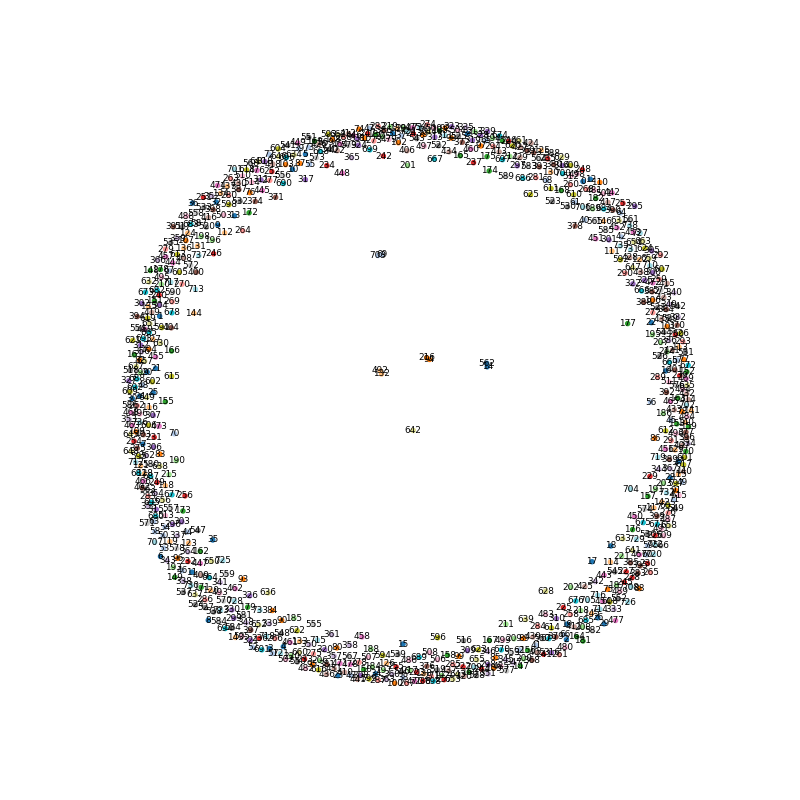

In [42]:
%matplotlib notebook
base = '/home/lars/kek/'

archivate = False
libs= False
graph_f = True
cluster_f = True


if(archivate):
    archivate_maps(data, names, levels=4)

if(libs):
    lib = graph_preparation(data, names, base) # создание ориентировочной библиотеки знакомств
    prob_lib = znakomstvo_by_lib(lib,data) # расчёт вероятностей для библиотеки

#Всё что нужно, это передать через base директорию, где лежат ключи и значения библиотек
#base Опциональный параметр load_libs

lib, prob_lib = load_libs(base = base)
print("Libs loaded")
if(graph_f):
    graph = graph_forming(lib, prob_lib, treshold=0.9)
print("Graph formed")
    
if(cluster_f):
    result = mc.run_mcl(graph,pruning_threshold=0.7, inflation=2,expansion=2)      
    print("Clustered")
    clusters = mc.get_clusters(result)

    clust_0 = clusters_to_ids(lib=lib, prob_lib=prob_lib, clusters = clusters, number = 0)
    maps = get_cluster_maps(data = data, clust = clust_0)
    print("Number of clusters", len(clusters))

    plt.figure(figsize=(10,10))
    mc.drawing.draw_graph(result, clusters, edge_color="red",node_size=15,width = 1, with_labels=True, font_size = 8)

In [19]:
len(clusters)

476

In [47]:
np.savez(base+"lib_keys", np.array(list(lib.keys())))
np.savez(base+"lib_values", np.array(list(lib.values())))
np.savez(base+"prob_lib_keys", np.array(list(prob_lib.keys())))
np.savez(base+"prob_lib_values", np.array(list(prob_lib.values())))

In [43]:
maps[0]